# Configuración Inicial

In [1]:
import sys
import os
import numpy as np

def setup_workdirectory(
    repo_url="https://github.com/kikaymusic/EscuderoRodriguezSanchez.git",
    branch="dev",
    repo_name="EscuderoRodriguezSanchez",
    directoy_name="Entornos_Complejos"
):
    """
    Función para detectar si el código se está ejecutando en Google Colab o en local
    y configurar el entorno de trabajo en consecuencia.
    """
    # Detectamos si estamos en Google Colab
    in_colab = "google.colab" in sys.modules

    if in_colab:
        print("Entorno detectado: Google Colab")

        # Definimos la ruta del repositorio en Colab
        repo_path = f"/content/{repo_name}"

        # Borramos el repositorio si ya existe para evitar conflictos
        if os.path.exists(repo_path):
            os.system(f"rm -rf {repo_path}")

        # Clonamos la rama especificada del repositorio
        os.system(f"git clone -b {branch} --single-branch {repo_url}")

        # Cambiamos al directorio del repositorio
        os.system(f"%cd {repo_path}")

        # Añadimos el directorio especificado al path
        sys.path.append(f'/content/{repo_name}/{directoy_name}')

    else:
        print("Entorno detectado: Local")

        # Añadir el directorio especificado al path de Python
        notebook_dir = os.path.dirname(os.path.abspath('__file__')) if '__file__' in globals() else os.getcwd()
        k_brazos_dir = notebook_dir if directoy_name in notebook_dir else os.path.join(notebook_dir, directoy_name)
        if k_brazos_dir not in sys.path:
            sys.path.insert(0, k_brazos_dir)


setup_workdirectory()

Entorno detectado: Local


# Imports

In [2]:
import gymnasium as gym
from src.train import train_agent
from src.agents.sarsa import AgentSarsa
from src.agents.qlearning import AgentQLearning
from src.utils import SEMILLA
from src.policies.epsilon_greedy import EpsilonGreedyPolicy
from src.policies.epsilon_soft import EpsilonSoftPolicy
from src.utils import q_to_v_and_policy
from src.UI import evaluate_agent_visual
import matplotlib.pyplot as plt
from src.plots import (
    plot_blackjack_values,
    plot_policy,
    plot_q_heatmap,
    plot_rewards,
    capture_figure,
    compare_plots
)

# Blackjack con Agente SARSA

Vamos a empezar ejecutando el entorno con el agente SARSA. Como es un algoritmo On-Policy, la política de comportamiento y la objetivo serán la misma, por lo que solo será necesario escoger una. En nuestro caso, vamos a elegir $\epsilon$-soft, ya que SARSA es un algoritmo que tiende a encontrar soluciones menos óptimas pero más seguras, y la exploración extra que nos proporciona $\epsilon$-soft nos beneficia siguiendo esta filosofía. Además, necesitamos una política que tenga mayor exploración para de que el algoritmo converja.

In [3]:
env = gym.make("Blackjack-v1", render_mode="rgb_array", sab=True)

# Inicializamos la política con la semilla
esoft_policy = EpsilonSoftPolicy(epsilon=0.1, n_actions=env.action_space.n, seed=SEMILLA)

# Inicializamos el agente SARSA con el entorno y la política
sarsa_agent = AgentSarsa(env, esoft_policy)

# Al iniciar el entrenamiento, le pasamos la semilla al entorno
state, info = env.reset(seed=SEMILLA)

In [4]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


## Visualización de juego pre-entrenamiento

In [5]:
results_before_on = evaluate_agent_visual(
    env, sarsa_agent,
    n_episodes=10,
    seed_base=SEMILLA,
    delay=0.2,
    greedy_eval=True
)
print(results_before_on)

{'wins': 1, 'losses': 8, 'draws': 1, 'win_rate': 10.0, 'episodes': 10}


## Entrenamiento del Agente

In [6]:
episode_returns_sarsa, episode_lengths_sarsa = train_agent(env, sarsa_agent)

Episode 5000/80000 - avg_return_last_5000=-0.1548
Episode 10000/80000 - avg_return_last_5000=-0.1090
Episode 15000/80000 - avg_return_last_5000=-0.1180
Episode 20000/80000 - avg_return_last_5000=-0.1330
Episode 25000/80000 - avg_return_last_5000=-0.1032
Episode 30000/80000 - avg_return_last_5000=-0.0864
Episode 35000/80000 - avg_return_last_5000=-0.0866
Episode 40000/80000 - avg_return_last_5000=-0.1048
Episode 45000/80000 - avg_return_last_5000=-0.1096
Episode 50000/80000 - avg_return_last_5000=-0.1032
Episode 55000/80000 - avg_return_last_5000=-0.1016
Episode 60000/80000 - avg_return_last_5000=-0.0916
Episode 65000/80000 - avg_return_last_5000=-0.0994
Episode 70000/80000 - avg_return_last_5000=-0.1018
Episode 75000/80000 - avg_return_last_5000=-0.1068
Episode 80000/80000 - avg_return_last_5000=-0.1052


## Resultados y Análisis

### Tendencia de recompensas

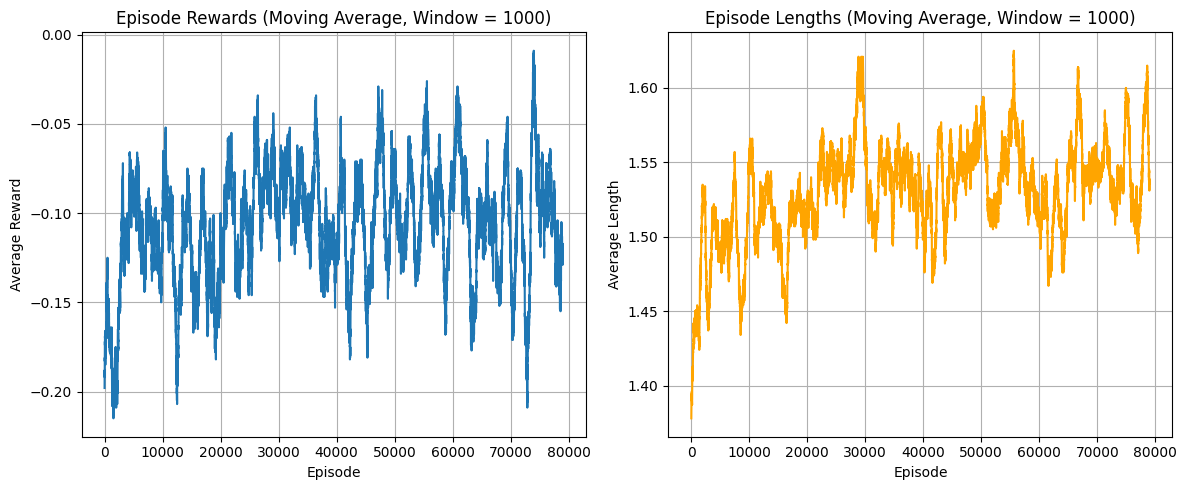

In [7]:
# Suponiendo que tienes las listas
plot_rewards(episode_returns_sarsa, episode_lengths_sarsa, window=1000)

### Superficie de Valores de Estado

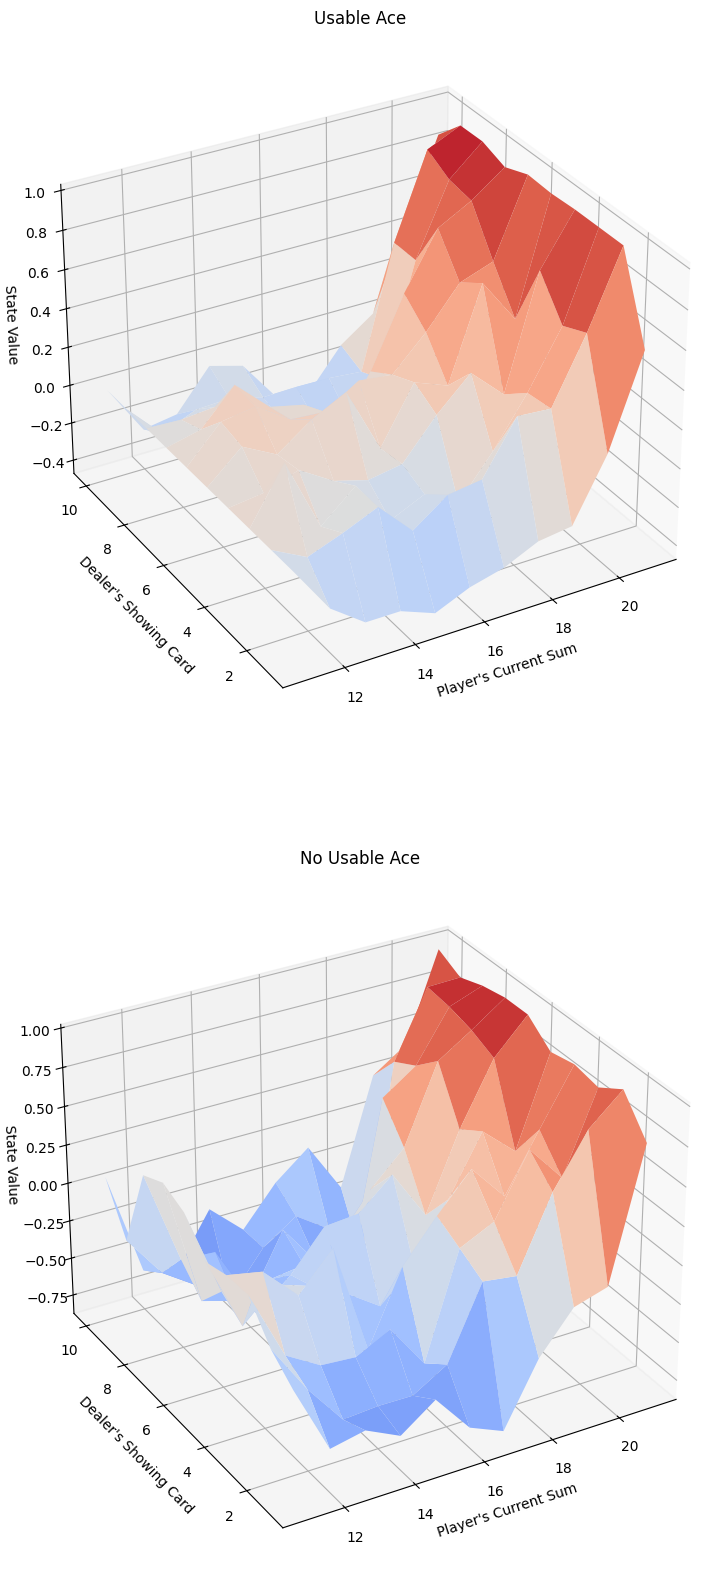

In [8]:
# 3) Value function + policy visualization
V_sarsa, policy_sarsa = q_to_v_and_policy(sarsa_agent.q_table)
plot_blackjack_values(V_sarsa)

### Mapa de Política Aprendida

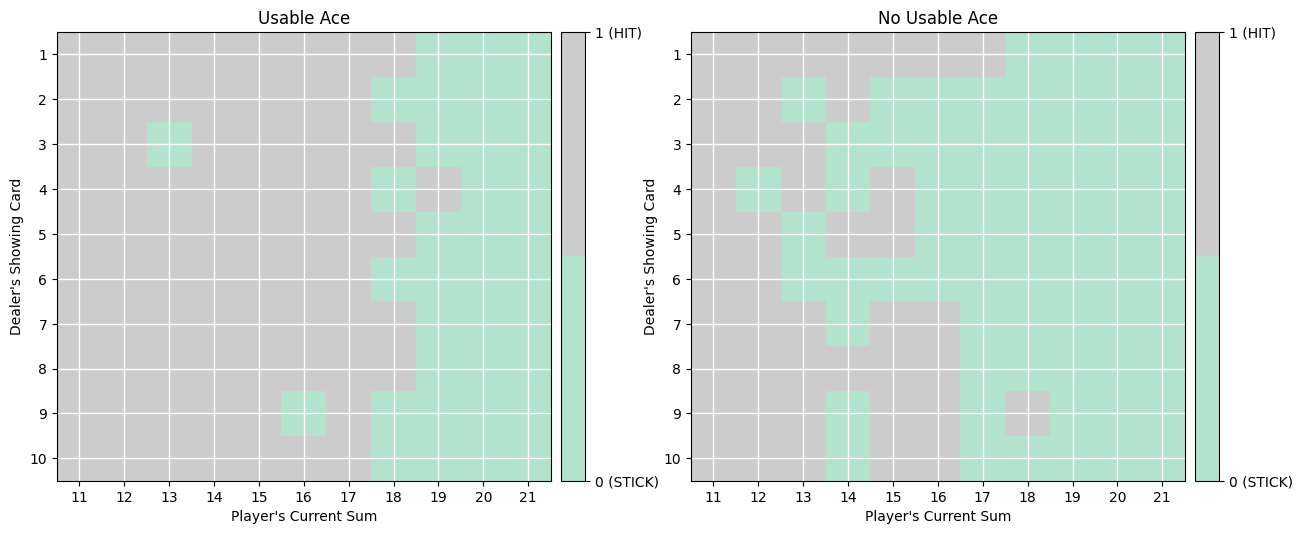

In [9]:
plot_policy(policy_sarsa)

### Distribución de Q-Valores por Acción dado un Estado

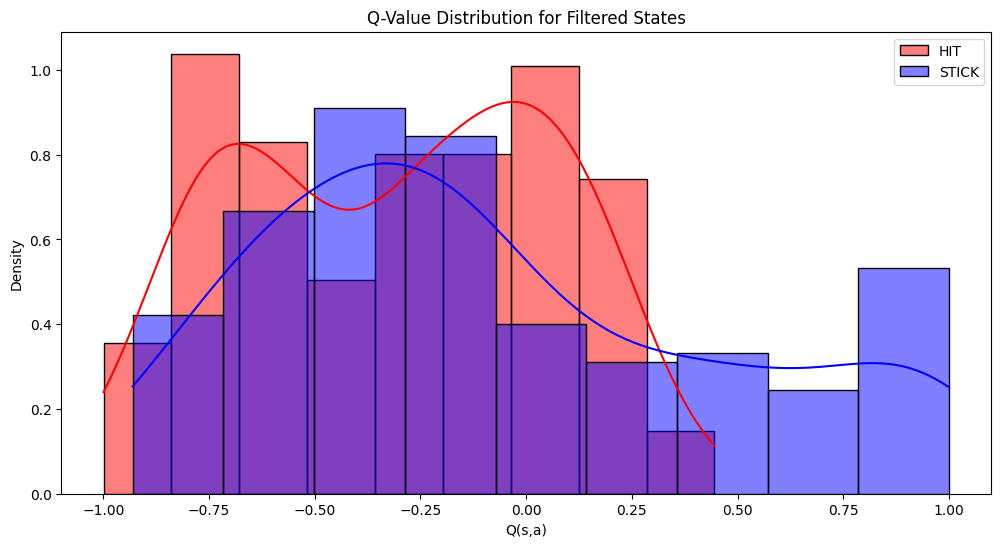

In [10]:
# 4) Extra: distribución de Q(s,a) en estados típicos (player sum 11..21)
plot_q_heatmap(
    sarsa_agent.q_table,
    state_filter_fn=lambda s: (isinstance(s, tuple) and len(s) == 3 and 11 <= s[0] <= 21),
)

# Blackjack con Agente Q-Learning

Ahora vamos a ejecutar el entorno con el agente Q-Learning. En este caso, como el algoritmo es Off-Policy, necesitaremos una política de comportamiento y otra objetivo. Para la política de comportamiento, hemos elegido $\epsilon$-soft, ya que la política de comportamiento es la encargada de generar datos y necesitamos una política que explore más para descubrir si hay mejores recompensas. Para la política objetivo, hemos elegido $\epsilon$-greedy, ya que necesitamos una política que explote las mejores acciones encontradas.

In [11]:
# Inicializamos las política con la semilla
behavior_policy_qlearning = EpsilonSoftPolicy(epsilon=0.1, n_actions=env.action_space.n, seed=SEMILLA)
target_policy_qlearning = EpsilonGreedyPolicy(epsilon=0.1, n_actions=env.action_space.n, seed=SEMILLA)

# Inicializamos el agente Q-Learning con el entorno y las políticas
qlearning_agent = AgentQLearning(env, behavior_policy_qlearning, target_policy_qlearning)

# Al iniciar el entrenamiento, le pasamos la semilla al entorno
state, info = env.reset(seed=SEMILLA)

In [12]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


## Visualización de juego pre-entrenamiento

In [13]:
results_before_on = evaluate_agent_visual(
    env, qlearning_agent,
    n_episodes=10,
    seed_base=SEMILLA,
    delay=0.2,
    greedy_eval=True
)
print(results_before_on)

{'wins': 1, 'losses': 8, 'draws': 1, 'win_rate': 10.0, 'episodes': 10}


## Entrenamiento del Agente

In [14]:
episode_returns_qlearning, episode_lengths_qlearning = train_agent(env, qlearning_agent)

Episode 5000/80000 - avg_return_last_5000=-0.1382
Episode 10000/80000 - avg_return_last_5000=-0.1068
Episode 15000/80000 - avg_return_last_5000=-0.1162
Episode 20000/80000 - avg_return_last_5000=-0.1248
Episode 25000/80000 - avg_return_last_5000=-0.1114
Episode 30000/80000 - avg_return_last_5000=-0.1010
Episode 35000/80000 - avg_return_last_5000=-0.1020
Episode 40000/80000 - avg_return_last_5000=-0.1168
Episode 45000/80000 - avg_return_last_5000=-0.1202
Episode 50000/80000 - avg_return_last_5000=-0.0948
Episode 55000/80000 - avg_return_last_5000=-0.1168
Episode 60000/80000 - avg_return_last_5000=-0.0884
Episode 65000/80000 - avg_return_last_5000=-0.1046
Episode 70000/80000 - avg_return_last_5000=-0.1106
Episode 75000/80000 - avg_return_last_5000=-0.1292
Episode 80000/80000 - avg_return_last_5000=-0.0956


## Resultados y Análisis

### Tendencia de recompensas

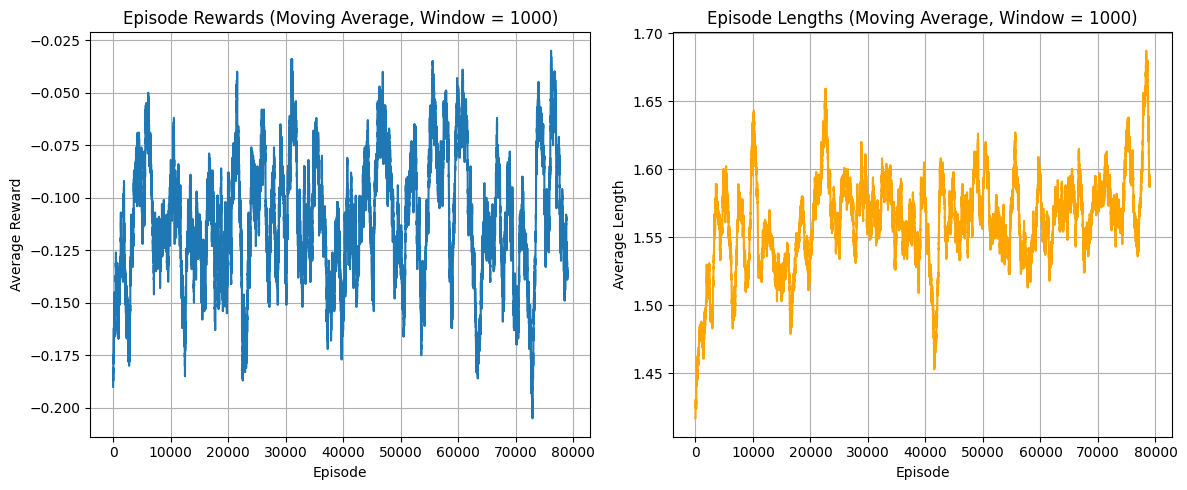

In [15]:
# Suponiendo que tienes las listas
plot_rewards(episode_returns_qlearning, episode_lengths_qlearning, window=1000)

### Superficie de Valores de Estado

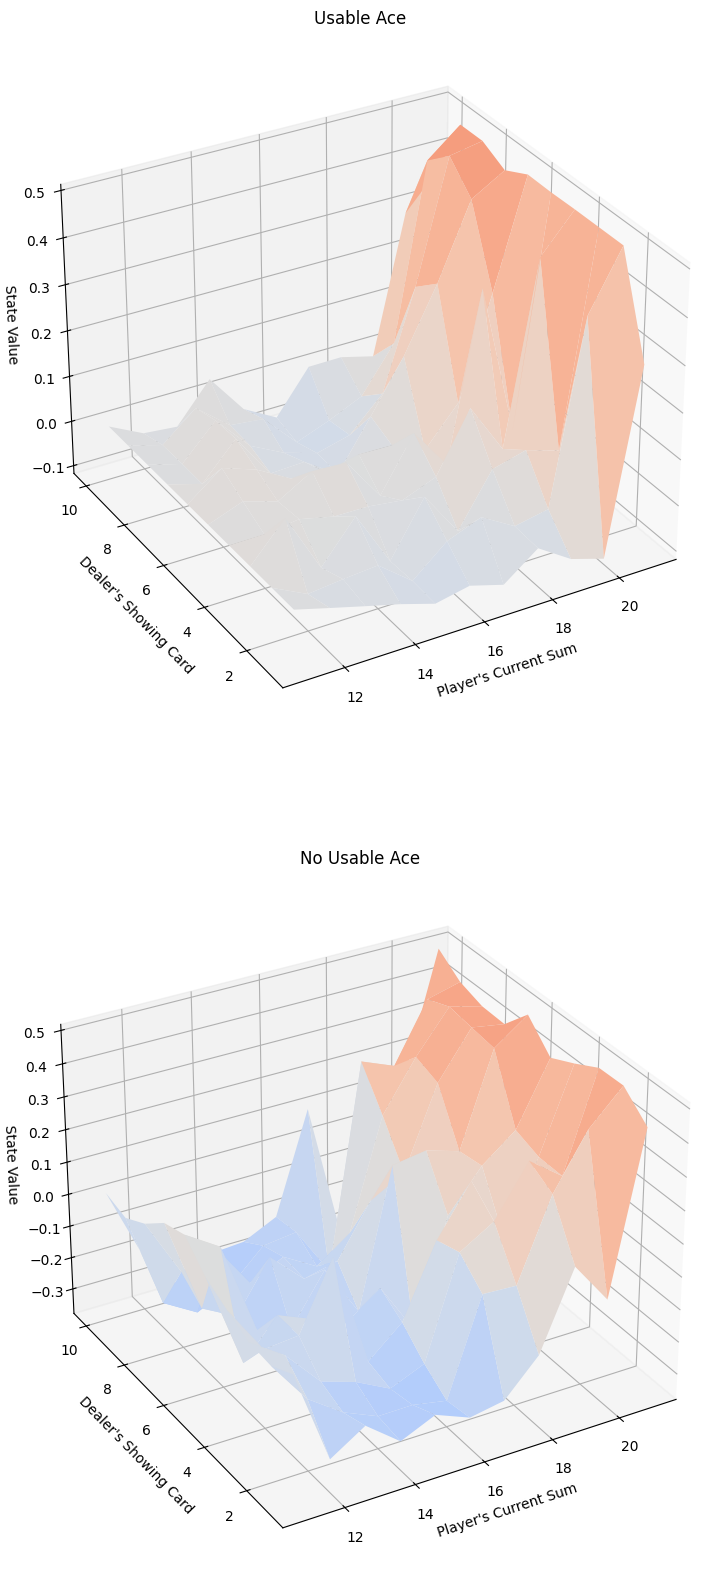

In [16]:
# 3) Value function + policy visualization
V_qlearning, policy_qlearning = q_to_v_and_policy(qlearning_agent.q_table)
plot_blackjack_values(V_qlearning)

### Mapa de Política Aprendida

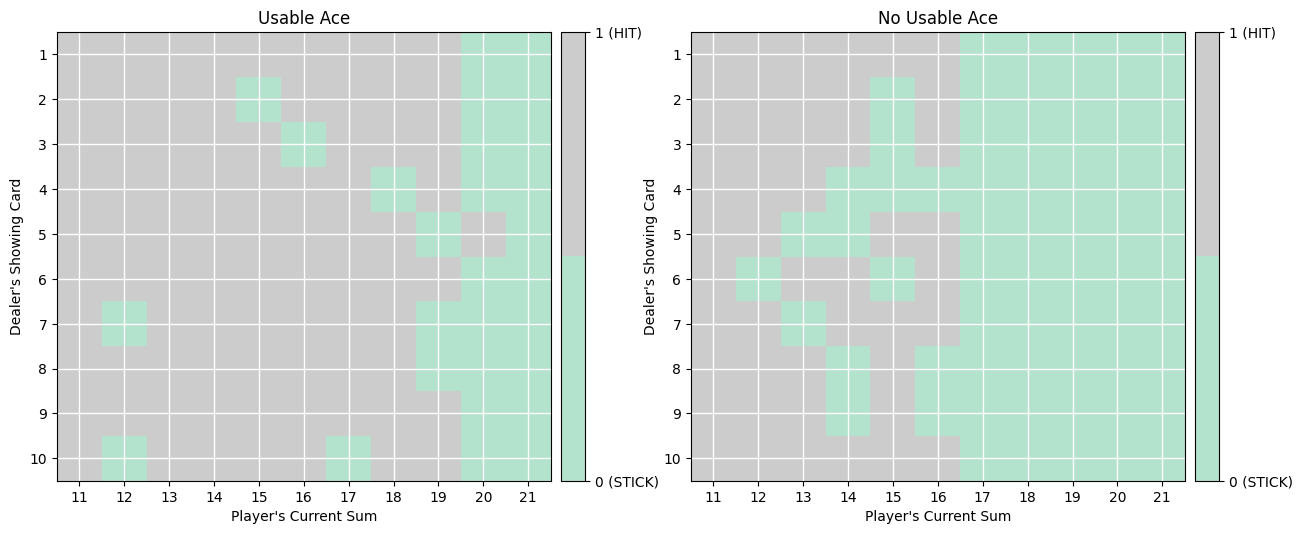

In [17]:
plot_policy(policy_qlearning)

### Distribución de Q-Valores por Acción dado un Estado

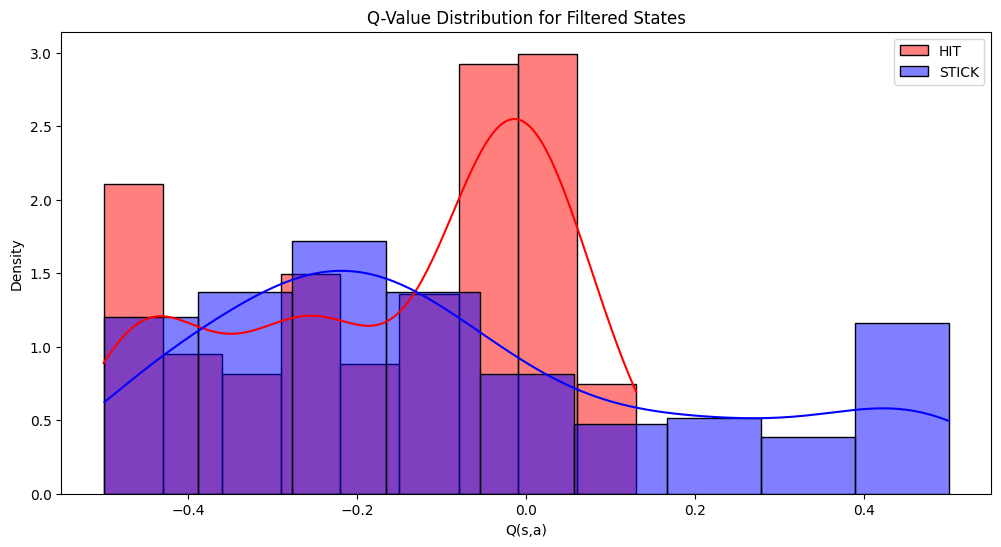

In [18]:
# 4) Extra: distribución de Q(s,a) en estados típicos (player sum 11..21)
plot_q_heatmap(
    qlearning_agent.q_table,
    state_filter_fn=lambda s: (isinstance(s, tuple) and len(s) == 3 and 11 <= s[0] <= 21),
)

# Comparativa entre agentes

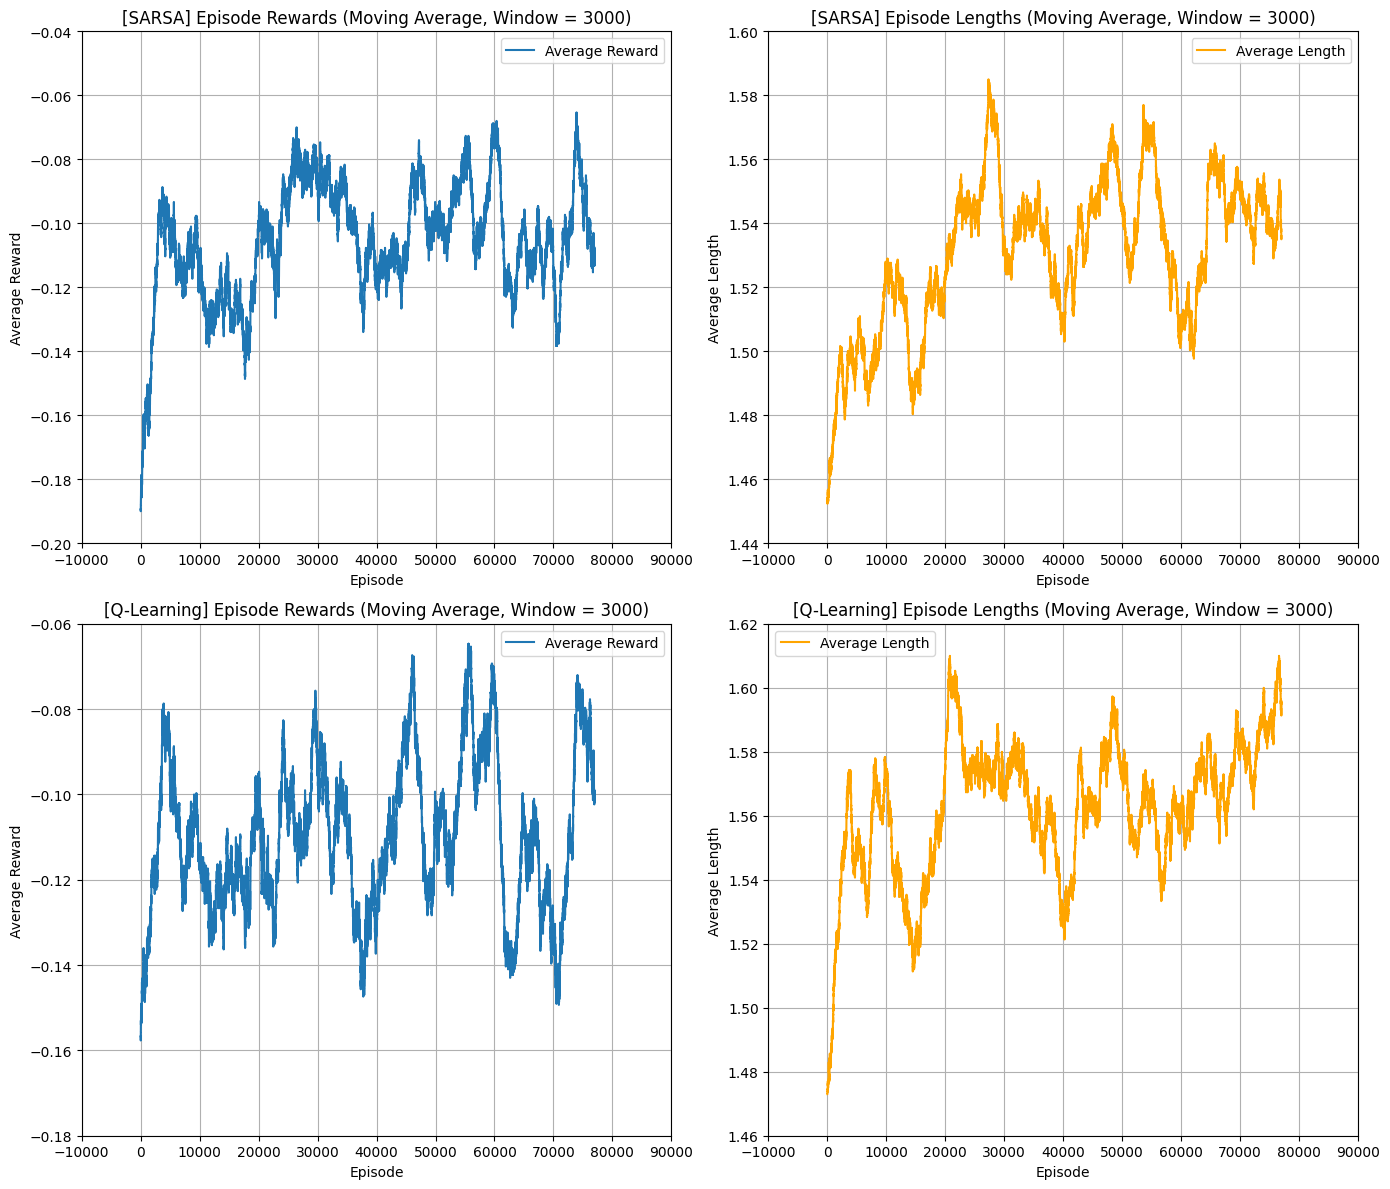

In [19]:
compare_plots(
    plot_rewards,
    agents_data=[(episode_returns_sarsa, episode_lengths_sarsa), (episode_returns_qlearning, episode_lengths_qlearning)],
    agent_names=["SARSA", "Q-Learning"],
    window=3000  # kwargs opcionales
)

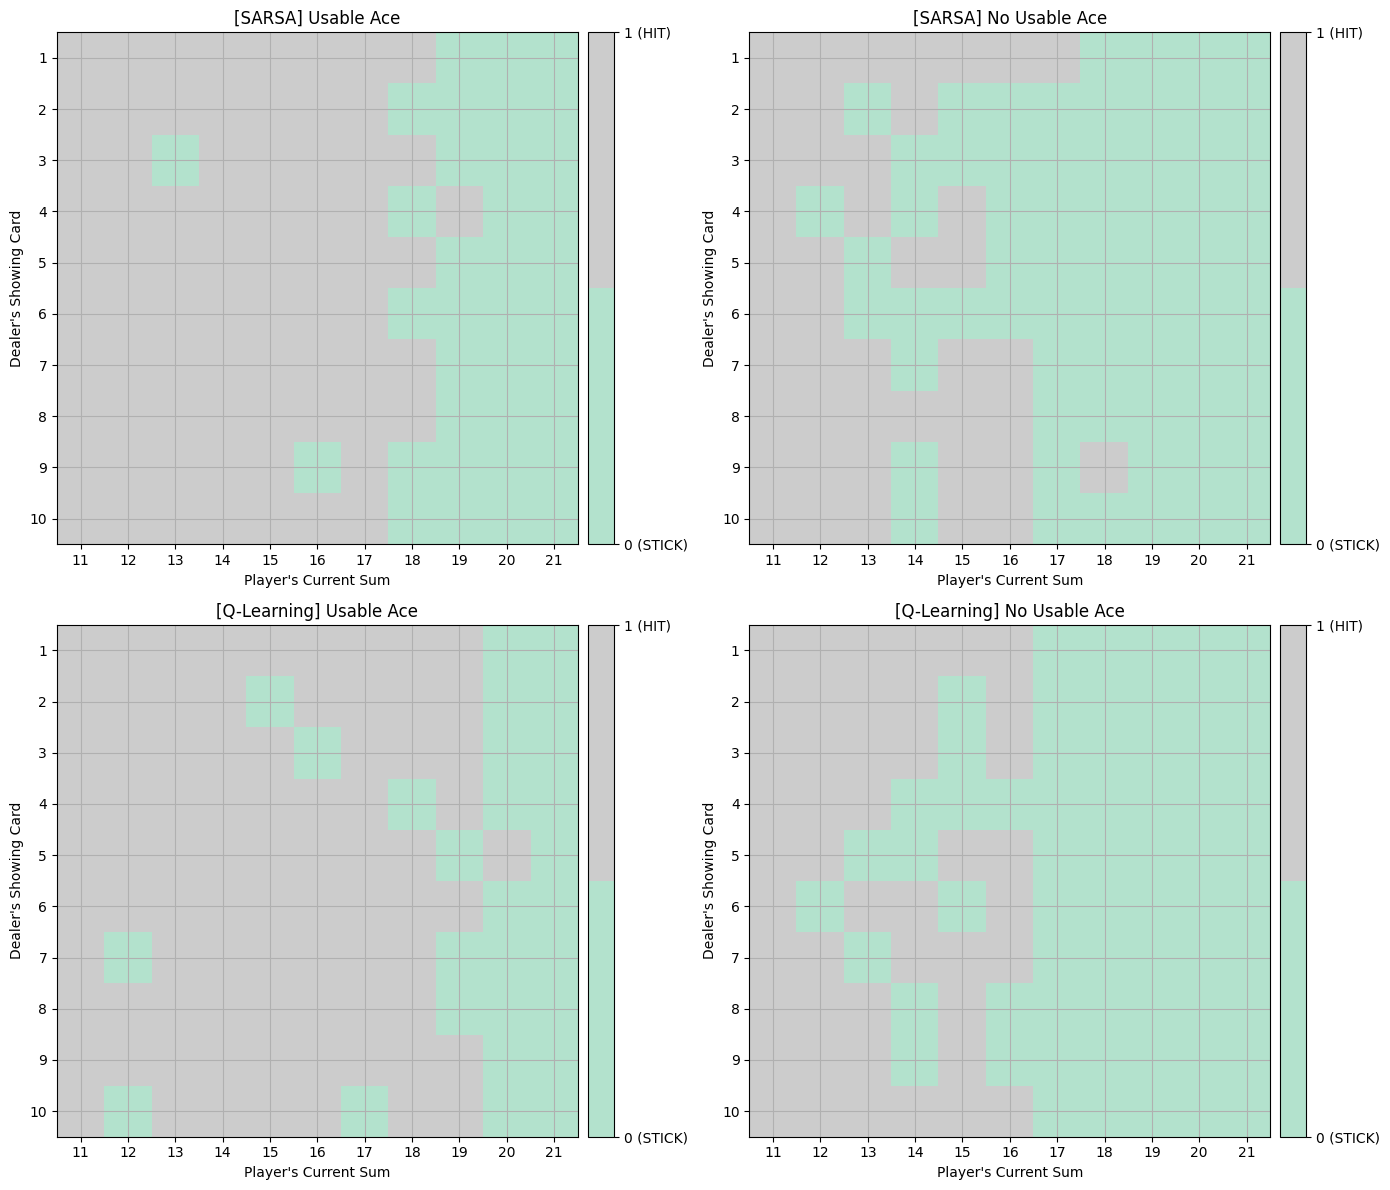

In [20]:
compare_plots(
    plot_policy,
    agents_data=[(policy_sarsa,), (policy_qlearning,)],
    agent_names=["SARSA", "Q-Learning"]
)

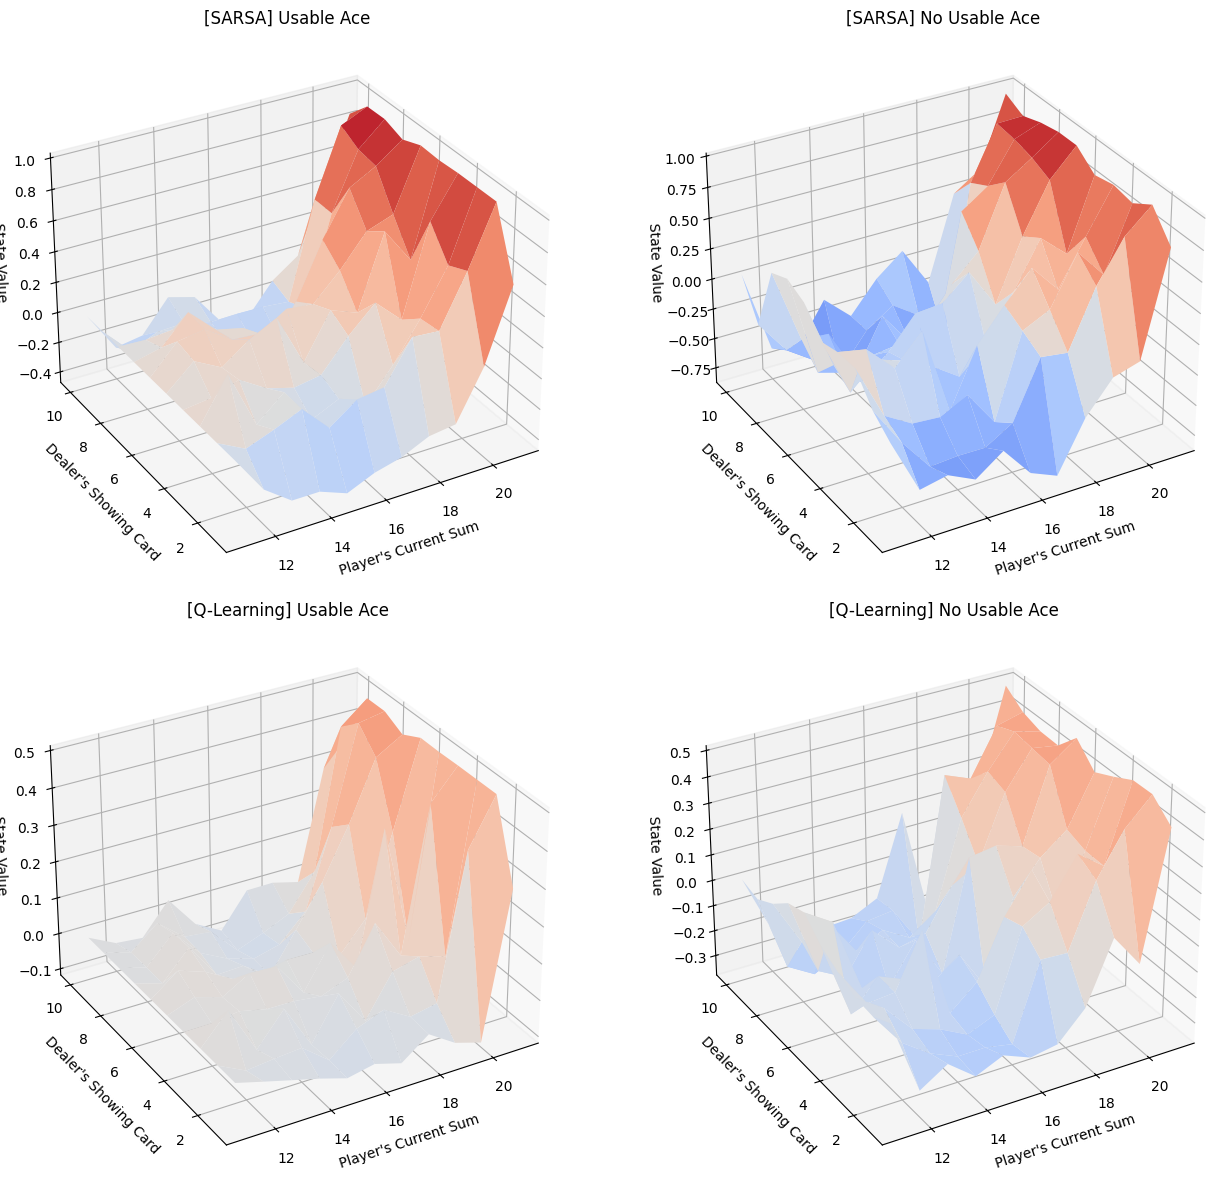

In [21]:
compare_plots(
    plot_blackjack_values,
    agents_data=[(V_sarsa,), (V_qlearning,)],
    agent_names=["SARSA", "Q-Learning"]
)